![banner_img](https://github.com/ShiJbey/neighborly/assets/11076525/3013afe0-2bcd-4908-bddf-31adcd8cbd7f)

# Sample Simulation: Demon Slayer

**Demon Slayer: Kimetsu no Yaiba** is a manga/anime series about the adventures of the main protagonist, Kamado Tanjiro, and his sister Kamado Nezuko. The story is set during the Taisho era in Japan (1912-1926) and focuses on a centuries-old conflict between the Demon Slayer Corps and demons. Demons prey on humans during the night, causing fear among humans. The Demon Slayer Corp fights demons to eradicate the threat. To fight the supernatural powers/strength of demons, demon slayers use elemental *breathing styles*. The strongest Demon Slayers are known as the Hashira and gain this rank by either killing a member of the Twelve Kizuki (the twelve strongest demons under Muzan) or killing fifty (50) demons after ranking up multiple times.

This sample simulates a Demon Slayer-style town where humans generally live mundane lives (growing up, forming relationships, working jobs, having families, etc.). However, at a designated point in the simulation, we introduce a single demon into the population. This demon is free to turn humans into demons or devour them to gain strength. Ordinary humans will have the option to become demon slayers and fight against demons. We simulate demons and demon slayers growing in rank. Demons have the option to challenge someone of higher ranking for their position.


## Key Features
- Regular people can turn into Demons
- Demons are immortal and cannot die of old age
- Regular people can become DemonSlayers
- As Demons and DemonSlayers defeat enemies,
  they grow in rank
- Demons can challenge higher-ranking demons for power
- The DemonSlayerCorp tracks the current highest
  ranking slayers
- The DemonKingdom tracks the top-12 ranked demons


## Copyright Disclaimer

This project is associated with the Demon Slayer series. All characters and story-specific terms are the property of their current copyright holder.

## References

- [https://en.wikipedia.org/wiki/Demon_Slayer:_Kimetsu_no_Yaiba](https://en.wikipedia.org/wiki/Demon_Slayer:_Kimetsu_no_Yaiba)
- [https://fictionhorizon.com/demon-slayer-ranks-in-order-every-rank-explained-and-sorted/](https://fictionhorizon.com/demon-slayer-ranks-in-order-every-rank-explained-and-sorted/)
- [https://kimetsu-no-yaiba.fandom.com/wiki/Breathing_Styles](https://kimetsu-no-yaiba.fandom.com/wiki/Breathing_Styles)
- [https://kimetsu-no-yaiba.fandom.com/wiki/Demon_Slayer_Corps#Positions](https://kimetsu-no-yaiba.fandom.com/wiki/Demon_Slayer_Corps#Positions)
- [https://kimetsu-no-yaiba.fandom.com/wiki/Twelve_Kizuki](https://kimetsu-no-yaiba.fandom.com/wiki/Twelve_Kizuki)
- [https://demonslayerrp.fandom.com/wiki/Slayer_Rankings](https://demonslayerrp.fandom.com/wiki/Slayer_Rankings)


# Import Dependencies

In [1]:
from __future__ import annotations

import enum
import math
import random
import time
from typing import Any, Dict, Generator, List, Optional, Tuple, ClassVar

from ordered_set import OrderedSet

from neighborly import (
    Neighborly,
    NeighborlyConfig,
    SimDateTime,
    System,
)
from neighborly.components.character import (
    CanAge,
    CanGetPregnant,
    GameCharacter,
    Immortal,
    LifeStage,
    LifeStageType,
    Fertility,
    BaseCharacter,
)
from neighborly.components.shared import FrequentedLocations
from neighborly.decorators import (
    component,
    on_event,
    random_life_event,
    resource,
    system,
)
from neighborly.ecs import Active, Component, GameObject, ISerializable, World
from neighborly.events import DeathEvent
from neighborly.exporter import export_to_json
from neighborly.life_event import (
    EventBindingContext,
    EventHistory,
    RandomLifeEvent,
    event_role,
    EventLog,
)
from neighborly.settlement import Settlement
from neighborly.stats import ClampedStatComponent, StatModifier, StatModifierType
from neighborly.systems import EarlyUpdateSystemGroup
from neighborly.utils.common import die

# Create Neighborly Simulation Instance

In [2]:
sim = Neighborly(
    NeighborlyConfig.parse_obj(
        {
            "logging": {
                "logging_enabled": False,
                "log_directory": ".",
            },
            "plugins": [
                "neighborly.plugins.defaults.all",
                "neighborly.plugins.talktown",
            ],
        }
    )
)

# Defining component types

Here we define simulation-specific component types that track information that we care about for this simulation.

In [3]:

class DemonSlayerRank(enum.IntEnum):
    """Various ranks within the DemonSlayerCorp by increasing seniority."""

    Mizunoto = 0
    Mizunoe = 15
    Kanoto = 30
    Kanoe = 50
    Tsuchinoto = 65
    Tsuchinoe = 80
    Hinoto = 100
    Hinoe = 120
    Kinoto = 140
    Kinoe = 160
    Hashira = 220


class BreathingStyle(enum.Enum):
    """Various breathing styles for demon slayers."""

    Flower = enum.auto()
    Love = enum.auto()
    Flame = enum.auto()
    Sun = enum.auto()
    Sound = enum.auto()
    Thunder = enum.auto()
    Wind = enum.auto()
    Water = enum.auto()
    Insect = enum.auto()
    Serpent = enum.auto()
    Moon = enum.auto()
    Stone = enum.auto()
    Mist = enum.auto()
    Beast = enum.auto()


@component(sim.world)
class PowerLevel(ClampedStatComponent[int]):
    """The strength of a character when in battle."""

    MAX_VALUE: ClassVar[int] = 255

    def __init__(self, base_value: int = 0) -> None:
        super().__init__(
            base_value=base_value, min_value=0, max_value=PowerLevel.MAX_VALUE
        )

    @classmethod
    def create(cls, gameobject: GameObject, **kwargs) -> PowerLevel:
        rng = gameobject.world.resource_manager.get_resource(random.Random)
        base_value = kwargs.get(
            "base_value", rng.randint(0, PowerLevel.MAX_VALUE - 50)
        )
        return PowerLevel(base_value=base_value)


@component(sim.world)
class ConfirmedKills(Component, ISerializable):
    """The number of enemies a character has defeated."""

    __slots__ = "count"

    count: int

    def __init__(self, count: int = 0) -> None:
        super().__init__()
        self.count = count

    def to_dict(self) -> Dict[str, Any]:
        return {"count": self.count}


@component(sim.world)
class DemonSlayer(Component):
    """A DemonSlayer is a character who fights demons and grows in rank."""

    __slots__ = "rank", "breathing_style", "demons_kills", "upper_moon_demon_kills"

    rank: DemonSlayerRank
    """The slayer's current rank."""

    breathing_style: BreathingStyle
    """The style of breathing this slayer uses."""

    demons_kills: int
    """The total number of demons this character has killed."""

    upper_moon_demon_kills: int
    """The number of upper moon-ranking demons killed by this character."""

    def __init__(self, breathing_style: BreathingStyle) -> None:
        super().__init__()
        self.rank = DemonSlayerRank.Mizunoto
        self.breathing_style = breathing_style
        self.demons_kills = 0
        self.upper_moon_demon_kills = 0

    def to_dict(self) -> Dict[str, Any]:
        return {
            "rank": self.rank.name,
            "breathing-style": self.breathing_style.name,
            "demon_kills": self.demons_kills,
            "upper_demon_kills": self.upper_moon_demon_kills,
        }

    @classmethod
    def create(cls, gameobject: GameObject, **kwargs) -> DemonSlayer:
        world = gameobject.world
        rng = world.resource_manager.get_resource(random.Random)
        breathing_style = rng.choice(list(BreathingStyle))
        return DemonSlayer(
            breathing_style=breathing_style,
        )


@resource(sim.world)
class DemonSlayerCorps:
    """A business owned by the simulation, responsible for employing demon slayers

    Attributes
    ----------
    _hashira: OrderedSet[int]
        Hashira still active in the town
    _former_hashira: OrderedSet[int]
        Hashira that are no longer active
    _hashira_styles: OrderedSet[int]
        Breathing styles of current Hashira
    _hashira_to_style: Dict[int, BreathingStyle]
        Map of Hashira IDs to Breathing styles
    """

    __slots__ = "_hashira", "_former_hashira", "_hashira_styles", "_hashira_to_style"

    def __init__(self) -> None:
        super().__init__()
        self._hashira: OrderedSet[GameObject] = OrderedSet([])
        self._hashira_styles: OrderedSet[BreathingStyle] = OrderedSet([])
        self._hashira_to_style: Dict[GameObject, BreathingStyle] = {}
        self._former_hashira: OrderedSet[GameObject] = OrderedSet([])

    @property
    def hashira(self) -> OrderedSet[GameObject]:
        """Get all current Hashira"""
        return self._hashira

    @property
    def former_hashira(self) -> OrderedSet[GameObject]:
        """Get all former Hashira."""
        return self._former_hashira

    def add_hashira(self, character: GameObject) -> None:
        """Add a new Hashira.

        Parameters
        ----------
        character
            The character to add as a Hashira.
        """
        self._hashira.add(character)
        self._hashira_styles.add(character.get_component(DemonSlayer).breathing_style)

    def retire_hashira(self, character: GameObject) -> None:
        """Remove a hashira from the active list.

        Parameters
        ----------
        character
            The hashira to remove
        """
        self._hashira.remove(character)
        self._former_hashira.add(character)
        self._hashira_styles.remove(self._hashira_to_style[character])
        del self._hashira_to_style[character]

    def has_vacancy(self, breathing_style: BreathingStyle) -> bool:
        """
        Return true if there is a vacancy for a Hashira
        with the given BreathingStyle

        Parameters
        ----------
        breathing_style: BreathingStyle
            The BreathingStyle to see if there is a vacancy for
        """
        return breathing_style in self._hashira_styles

    def to_dict(self) -> Dict[str, Any]:
        return {
            "hashira": list(self.hashira),
            "former_hashira": list(self.former_hashira),
        }


class DemonRank(enum.IntEnum):
    """The various ranks held by demons"""

    LowerDemon = 0
    Demon = 40
    BloodDemon = 80
    HigherDemon = 120
    SuperiorDemon = 160
    LowerMoon = 200
    UpperMoon = 220


@component(sim.world)
class Demon(Component):
    """Demons eat people and battle each other and demon slayers."""

    __slots__ = "rank", "turned_by", "humans_devoured", "hashira_kills"

    rank: DemonRank
    """The general rank of the demon compared to other demons."""

    turned_by: Optional[GameObject]
    """The Demon that turned this character into a demon."""

    humans_devoured: int
    """The number of humans this demon has devoured."""

    hashira_kills: int
    """The number of hashira this demon has killed."""

    def __init__(
        self,
        rank: DemonRank = DemonRank.LowerDemon,
        turned_by: Optional[GameObject] = None,
    ) -> None:
        super().__init__()
        self.rank = rank
        self.turned_by = turned_by
        self.humans_devoured = 0
        self.hashira_kills = 0

    def on_add(self) -> None:
        self.gameobject.get_component(Fertility).add_modifier(
            StatModifier(
                value=-5000.0, modifier_type=StatModifierType.PercentAdd, source=self
            )
        )

    def on_remove(self) -> None:
        self.gameobject.get_component(Fertility).remove_modifiers_from_source(self)

    def to_dict(self) -> Dict[str, Any]:
        return {
            "rank": str(self.rank.name),
            "turned_by": self.turned_by if self.turned_by else -1,
            "humans_devoured": self.humans_devoured,
            "hashira_kills": self.hashira_kills,
        }


@resource(sim.world)
class DemonKingdom:
    """
    Manages information about the upper-ranked demons

    Attributes
    ----------
    _upper_moons: OrderedSet[int]
        The demons ranked as UpperMoon
    _former_upper_moons: OrderedSet[int]
        The demons that were formerly ranked as UpperMoon
    _lower_moons: OrderedSet[int]
        The demons ranked as LowerMoon
    _former_lower_moons: OrderedSet[int]
        The demons that were formerly ranked as LowerMoon
    """

    MAX_UPPER_MOONS = 6
    MAX_LOWER_MOONS = 6

    __slots__ = (
        "_lower_moons",
        "_upper_moons",
        "_former_upper_moons",
        "_former_lower_moons",
    )

    def __init__(self) -> None:
        self._lower_moons: OrderedSet[int] = OrderedSet([])
        self._upper_moons: OrderedSet[int] = OrderedSet([])
        self._former_lower_moons: OrderedSet[int] = OrderedSet([])
        self._former_upper_moons: OrderedSet[int] = OrderedSet([])

    @property
    def upper_moons(self) -> OrderedSet[int]:
        """Get current Upper Moons"""
        return self._upper_moons

    @property
    def lower_moons(self) -> OrderedSet[int]:
        """Get current Lower Moons"""
        return self._upper_moons

    @property
    def former_upper_moons(self) -> OrderedSet[int]:
        """Get former Upper Moons"""
        return self._former_upper_moons

    @property
    def former_lower_moons(self) -> OrderedSet[int]:
        """Get former Lower Moons"""
        return self._former_upper_moons

    def add_lower_moon(self, gid: int) -> None:
        """Add a new LowerMoon demon"""
        self._lower_moons.add(gid)

    def retire_lower_moon(self, gid: int) -> None:
        """Remove LowerMoon demon"""
        self._lower_moons.remove(gid)

    def add_upper_moon(self, gid: int) -> None:
        """Add a new UpperMoon demon"""
        self._upper_moons.add(gid)

    def retire_upper_moon(self, gid: int) -> None:
        """Remove UpperMoon demon"""
        self._upper_moons.remove(gid)

    def has_lower_moon_vacancy(self) -> bool:
        """Return true if there are sport available as LowerMoons"""
        return len(self._lower_moons) < DemonKingdom.MAX_LOWER_MOONS

    def has_upper_moon_vacancy(self) -> bool:
        """Return true if there are sport available as LowerMoons"""
        return len(self._upper_moons) < DemonKingdom.MAX_UPPER_MOONS

    def to_dict(self) -> Dict[str, Any]:
        return {
            "lower_moons": list(self.lower_moons),
            "former_lower_moons": list(self.lower_moons),
            "upper_moons": list(self.upper_moons),
            "former_upper_moons": list(self.former_upper_moons),
        }


# Helper Functions

In [4]:

def probability_of_winning(rating_a: int, rating_b: int) -> float:
    """
    Return the probability of a defeating b

    Parameters
    ----------
    rating_a: int
        Rating of entity A
    rating_b: int
        Rating of entity B
    """
    return 1.0 / (1 + math.pow(10, (rating_a - rating_b) / PowerLevel.MAX_VALUE))


def update_power_level(
    winner_rating: int,
    loser_rating: int,
    winner_expectation: float,
    loser_expectation: float,
    k: int = 16,
) -> Tuple[int, int]:
    """
    Perform ELO calculation for new ratings

    Parameters
    ----------
    winner_rating
    loser_rating
    winner_expectation
    loser_expectation
    k

    Returns
    -------
    Tuple[int, int]

    """
    new_winner_rating: int = round(winner_rating + k * (1 - winner_expectation))
    new_winner_rating = min(PowerLevel.MAX_VALUE, max(0, new_winner_rating))
    new_loser_rating: int = round(loser_rating + k * (0 - loser_expectation))
    new_loser_rating = min(PowerLevel.MAX_VALUE, max(0, new_loser_rating))

    return new_winner_rating, new_loser_rating


def battle(challenger: GameObject, opponent: GameObject) -> None:
    """Two characters fight."""
    world = challenger.world
    rng = world.resource_manager.get_resource(random.Random)
    challenger_pl = challenger.get_component(PowerLevel)
    opponent_pl = opponent.get_component(PowerLevel)

    challenger_success_chance = probability_of_winning(
        challenger_pl.value, opponent_pl.value
    )

    opponent_success_chance = probability_of_winning(
        opponent_pl.value, challenger_pl.value
    )

    if rng.random() < challenger_success_chance:
        # Challenger wins
        new_challenger_pl, _ = update_power_level(
            challenger_pl.value,
            opponent_pl.value,
            challenger_success_chance,
            opponent_success_chance,
        )

        challenger_pl.base_value = new_challenger_pl

        die(opponent)

        challenger.get_component(ConfirmedKills).count += 1
    else:
        # Opponent wins
        _, new_opponent_pl = update_power_level(
            opponent_pl.value,
            challenger_pl.value,
            opponent_success_chance,
            challenger_success_chance,
        )

        opponent_pl.base_value = new_opponent_pl

        die(challenger)

        opponent.get_component(ConfirmedKills).count += 1


def power_level_to_slayer_rank(power_level: int) -> DemonSlayerRank:
    """
    Convert a power level to the corresponding demon slayer rank

    Note
    ----
    This exudes Hashira as this is a special rank and is not granted
    automatically
    """
    if power_level >= DemonSlayerRank.Kinoe:
        return DemonSlayerRank.Kinoe
    elif power_level >= DemonSlayerRank.Kinoto:
        return DemonSlayerRank.Kinoto
    elif power_level >= DemonSlayerRank.Hinoe:
        return DemonSlayerRank.Hinoe
    elif power_level >= DemonSlayerRank.Hinoto:
        return DemonSlayerRank.Hinoto
    elif power_level >= DemonSlayerRank.Tsuchinoe:
        return DemonSlayerRank.Tsuchinoe
    elif power_level >= DemonSlayerRank.Tsuchinoto:
        return DemonSlayerRank.Tsuchinoto
    elif power_level >= DemonSlayerRank.Kanoe:
        return DemonSlayerRank.Kanoe
    elif power_level >= DemonSlayerRank.Kanoto:
        return DemonSlayerRank.Kanoto
    elif power_level >= DemonSlayerRank.Mizunoe:
        return DemonSlayerRank.Mizunoe
    else:
        return DemonSlayerRank.Mizunoto


def power_level_to_demon_rank(power_level: int) -> DemonRank:
    """
    Return Demon rank corresponding to a power level

    Note
    ----
    This exudes LowerMoon and UpperMoon as these are special ranks
    and are not granted automatically
    """
    if power_level >= DemonRank.UpperMoon:
        return DemonRank.UpperMoon
    elif power_level >= DemonRank.LowerMoon:
        return DemonRank.LowerMoon
    elif power_level >= DemonRank.SuperiorDemon:
        return DemonRank.SuperiorDemon
    elif power_level >= DemonRank.HigherDemon:
        return DemonRank.HigherDemon
    elif power_level >= DemonRank.BloodDemon:
        return DemonRank.BloodDemon
    elif power_level >= DemonRank.Demon:
        return DemonRank.Demon
    else:
        return DemonRank.LowerDemon


In [5]:
from tqdm.notebook import trange

def run_sim_for(sim: Neighborly, years: int) -> None:
    """Run the simulation for a given number of years and display a progress bar.

    Parameters
    ----------
    sim
        A Neighborly simulation instance.
    years
        The number of years to simulate.
    """

    # tqdm requires needs to know the number of iterations beforehand.
    # So, we need to calculate how many timesteps are in the given number
    # of years (rounding up to the nearest whole number)
    for _ in trange(years):
        sim.step()

# Define Random Events

Here we define random events that can happen to characters. Random events are also another way of defining character behavior. We use these events to build emergent stories.

In [6]:
@random_life_event(sim.world)
class BecomeDemonSlayer(RandomLifeEvent):
    @staticmethod
    @event_role("Character")
    def character(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        """Bind a character."""

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((GameCharacter, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            if character.has_component(DemonSlayer):
                continue
            if character.has_component(Demon):
                continue
            if character.get_component(LifeStage).life_stage >= LifeStageType.Child:
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)

        rng.shuffle(matches)

        for match in matches:
            yield (match,)

    def execute(self) -> None:
        character = self["Character"]
        character.add_component(DemonSlayer)

        self.world.resource_manager.get_resource(EventLog).append(self)
        character.get_component(EventHistory).append(self)


@random_life_event(sim.world)
class DemonSlayerPromotion(RandomLifeEvent):
    def execute(self) -> None:
        character = self["Character"]
        slayer = character.get_component(DemonSlayer)
        power_level_rank = power_level_to_slayer_rank(
            int(character.get_component(PowerLevel).value)
        )
        slayer.rank = power_level_rank

    @staticmethod
    @event_role("Character")
    def bind_opponent(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((DemonSlayer, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            demon_slayer = character.get_component(DemonSlayer)
            power_level = character.get_component(PowerLevel)
            power_level_rank = power_level_to_slayer_rank(int(power_level.value))

            if power_level_rank < demon_slayer.rank:
                matches.append(character)

        if matches:
            for m in matches:
                yield m

        return None


@random_life_event(sim.world)
class DemonChallengeForPower(RandomLifeEvent):
    def execute(self) -> None:
        """Execute the battle"""
        challenger = self["Challenger"]
        opponent = self["Opponent"]

        battle(challenger, opponent)

    @staticmethod
    @event_role("Challenger")
    def bind_challenger(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        """Get a challenger demon that has someone above them"""

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            demon = character.get_component(Demon)
            if demon.rank < DemonRank.UpperMoon:
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)
        for m in matches:
            yield m

        return

    @staticmethod
    @event_role("Opponent")
    def bind_opponent(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        """Find an opponent for the challenger"""

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        challenger = ctx.bindings["Challenger"]

        matches: List[GameObject] = []

        for character in candidates:
            if character == challenger:
                continue

            if (
                character.get_component(Demon).rank
                > challenger.get_component(Demon).rank
            ):
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)

        for m in matches:
            yield m

        return None


@random_life_event(sim.world)
class DevourHuman(RandomLifeEvent):
    def execute(self) -> None:
        demon = self["Demon"]
        victim = self["Victim"]

        if victim.has_component(DemonSlayer):
            battle(demon, victim)

        else:
            demon.get_component(PowerLevel).base_value += 1
            demon.get_component(Demon).rank = power_level_to_demon_rank(
                int(demon.get_component(PowerLevel).base_value)
            )
            die(victim)
            demon.get_component(EventHistory).append(self)
            self.world.resource_manager.get_resource(EventLog).append(self)

    @staticmethod
    @event_role("Demon")
    def bind_demon(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(candidates)

        for c in candidates:
            yield c

        return

    @staticmethod
    @event_role("Victim")
    def bind_opponent(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        """Get all people at the same location who are not demons"""
        demon = ctx.bindings["Demon"]

        demon_frequented_locations = OrderedSet(
            demon.get_component(FrequentedLocations)
        )

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((GameCharacter, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            if character == demon:
                continue

            if character.has_component(Demon):
                # skip
                continue

            character_frequented = OrderedSet(
                character.get_component(FrequentedLocations)
            )

            shared_locations = demon_frequented_locations.intersection(
                character_frequented
            )

            if len(shared_locations) > 0:
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)

        for m in matches:
            yield m

        return


@random_life_event(sim.world)
class Battle(RandomLifeEvent):
    """Have a demon fight a demon slayer"""

    def execute(self) -> None:
        """Choose a winner based on their expected success"""
        challenger = self["Challenger"]
        opponent = self["Opponent"]

        battle(challenger, opponent)
        challenger.get_component(EventHistory).append(self)
        opponent.get_component(EventHistory).append(self)
        self.world.resource_manager.get_resource(EventLog).append(self)

    @staticmethod
    @event_role("Challenger")
    def bind_challenger(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(candidates)
        for c in candidates:
            yield c

        return

    @staticmethod
    @event_role("Opponent")
    def bind_opponent(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((DemonSlayer, Active))
        ]

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(candidates)

        for c in candidates:
            yield c

        return None


@random_life_event(sim.world)
class TurnSomeoneIntoDemon(RandomLifeEvent):
    @staticmethod
    @event_role("Demon")
    def bind_demon(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(candidates)
        for c in candidates:
            yield (c, )

        return

    @staticmethod
    @event_role("NewDemon")
    def bind_human(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        demon = ctx.bindings["Demon"]

        demon_frequented_locations = OrderedSet(
            demon.get_component(FrequentedLocations)
        )

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((GameCharacter, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            if character == demon:
                continue

            if character.has_component(Demon):
                # skip
                continue

            character_frequented = OrderedSet(
                character.get_component(FrequentedLocations)
            )

            shared_locations = demon_frequented_locations.intersection(
                character_frequented
            )

            if len(shared_locations) > 0:
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)
        for m in matches:
            yield m

        return None

    def execute(self) -> None:
        demon = self["Demon"]
        new_demon = self["NewDemon"]

        new_demon.add_component(Demon, turned_by=demon.uid)
        new_demon.remove_component(CanAge)
        if new_demon.has_component(CanGetPregnant):
            new_demon.remove_component(CanGetPregnant)
        new_demon.get_component(PowerLevel).base_value = max(
            new_demon.get_component(PowerLevel).base_value,
            demon.get_component(PowerLevel).base_value // 2,
        )
        new_demon.add_component(ConfirmedKills)

        new_demon.get_component(EventHistory).append(self)
        demon.get_component(EventHistory).append(self)
        self.world.resource_manager.get_resource(EventLog).append(self)


@random_life_event(sim.world)
class PromotionToLowerMoon(RandomLifeEvent):
    def execute(self) -> None:
        character = self["Character"]
        character.get_component(Demon).rank = DemonRank.LowerMoon

        character.get_component(EventHistory).append(self)
        self.world.resource_manager.get_resource(EventLog).append(self)

    @staticmethod
    @event_role("Character")
    def bind_demon(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        demon_kingdom = ctx.world.resource_manager.get_resource(DemonKingdom)

        if not demon_kingdom.has_lower_moon_vacancy():
            return None

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            demon = character.get_component(Demon)
            power_level = character.get_component(PowerLevel)
            if (
                demon.rank < DemonRank.LowerMoon
                and int(power_level.value) >= DemonRank.LowerMoon
            ):
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)
        for m in matches:
            yield m

        return None


@random_life_event(sim.world)
class PromotionToUpperMoon(RandomLifeEvent):
    def execute(self) -> None:
        character = self["Character"]
        character.get_component(Demon).rank = DemonRank.UpperMoon

        character.get_component(EventHistory).append(self)
        self.world.resource_manager.get_resource(EventLog).append(self)

    @staticmethod
    @event_role("Character")
    def bind_demon(
        ctx: EventBindingContext,
    ) -> Generator[Tuple[GameObject, ...], None, None]:
        demon_kingdom = ctx.world.resource_manager.get_resource(DemonKingdom)

        if not demon_kingdom.has_upper_moon_vacancy():
            return

        candidates = [
            ctx.world.gameobject_manager.get_gameobject(g)
            for g, _ in ctx.world.get_components((Demon, Active))
        ]

        matches: List[GameObject] = []

        for character in candidates:
            demon = character.get_component(Demon)
            power_level = character.get_component(PowerLevel)
            if (
                demon.rank < DemonRank.UpperMoon
                and int(power_level.value) >= DemonRank.UpperMoon
            ):
                matches.append(character)

        rng = ctx.world.resource_manager.get_resource(random.Random)
        rng.shuffle(matches)

        for m in matches:
            yield m

        return


# Define event handlers

Sometimes we want to know when certain events happen to characters. We may want to update its components or the components of other GameObjects to reflect this event. Here we listen for `DeathEvent`s and handle them differently based on if they are a Hashira or a Demon.

In [7]:

@on_event(sim.world, DeathEvent)
def handle_hashira_death(event: DeathEvent) -> None:
    if demon_slayer := event.character.try_component(DemonSlayer):
        if demon_slayer.rank == DemonSlayerRank.Hashira:
            event.character.world.resource_manager.get_resource(
                DemonSlayerCorps
            ).retire_hashira(event.character)


@on_event(sim.world, DeathEvent)
def handle_demon_death(event: DeathEvent) -> None:
    if demon := event.character.try_component(Demon):
        if demon.rank == DemonRank.LowerMoon:
            event.character.world.resource_manager.get_resource(
                DemonKingdom
            ).retire_lower_moon(event.character.uid)
        elif demon.rank == DemonRank.UpperMoon:
            event.character.world.resource_manager.get_resource(
                DemonKingdom
            ).retire_upper_moon(event.character.uid)


# Spawn the first demon

We create a simple system that chooses an active character in the simulation and turns them into a demon. From here, they are free to make demon choices and engage in demon behavior.

In [8]:
@system(sim.world, system_group=EarlyUpdateSystemGroup)
class SpawnFirstDemonSystem(System):
    """Picks an existing character at random and turns them into a demon."""

    YEAR_TO_SPAWN_DEMON = 10

    def on_update(self, world: World) -> None:
        date = world.resource_manager.get_resource(SimDateTime)
        rng = world.resource_manager.get_resource(random.Random)

        if date.year < self.YEAR_TO_SPAWN_DEMON:
            return

        # Find active young adult or adult characters to choose from
        candidates = [
            world.gameobject_manager.get_gameobject(guid)
            for guid, (_, _, life_stage) in world.get_components(
                (GameCharacter, Active, LifeStage)
            )
            if life_stage.life_stage == LifeStageType.YoungAdult
            or life_stage.life_stage == LifeStageType.Adult
        ]

        new_demon = rng.choice(candidates)

        new_demon.add_component(Demon)

        new_demon.get_component(
            PowerLevel
        ).base_value = world.resource_manager.get_resource(random.Random).randint(
            0, DemonRank.HigherDemon
        )

        # Demons stop changing life stages and do not die of old age.
        new_demon.remove_component(CanAge)
        new_demon.add_component(Immortal)

        # Deactivate this system so that it only runs once.
        self.set_active(False)


# Add components to default character model

In [9]:
BaseCharacter.add_default_component(PowerLevel)
BaseCharacter.add_default_component(ConfirmedKills)

# Track Population Size

A simple system to create is one that tracks the population size each year. We define it as an ECS system that runs during the early-update phase of a simulation step and counts the number of active characters in the simulation

In [10]:
from neighborly.data_collection import DataCollector
from neighborly.systems import DataCollectionSystemGroup
from neighborly.time import SimDateTime

@system(sim.world, system_group=DataCollectionSystemGroup)
class TrackPopulation(System):

    last_recorded_year = 0

    def on_add(self, world):
        world.resource_manager.get_resource(DataCollector).create_new_table(
            "population", ("timestamp", "population", "demons", "demon_slayers")
        )

    def on_update(self, world):
        dc = world.resource_manager.get_resource(DataCollector)
        current_date = world.resource_manager.get_resource(SimDateTime)

        if current_date.year > self.last_recorded_year:
            population = len(world.get_components((Active, GameCharacter)))
            demons = len(world.get_components((Active, Demon)))
            demon_slayers = len(world.get_components((Active, DemonSlayer)))
            
            dc.add_table_row(
                "population", 
                {
                    "timestamp": current_date.year, 
                    "population": population, 
                    "demons": demons,
                    "demon_slayers": demon_slayers,
                }
            )
            self.last_recorded_year = current_date.year

# Run the Simulation!

In [11]:
from neighborly.time import SimDateTime
from neighborly.settlement import Settlement

run_sim_for(sim, years=100)

print(f"World Year: {sim.world.resource_manager.get_resource(SimDateTime).year}")
print(f"Settlement: {sim.world.resource_manager.get_resource(Settlement).name}")

  0%|          | 0/100 [00:00<?, ?it/s]

World Year: 101
Settlement: Fairfield


# Visualize the Population Over Time

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Population of Simulation (seed: 4345936)')

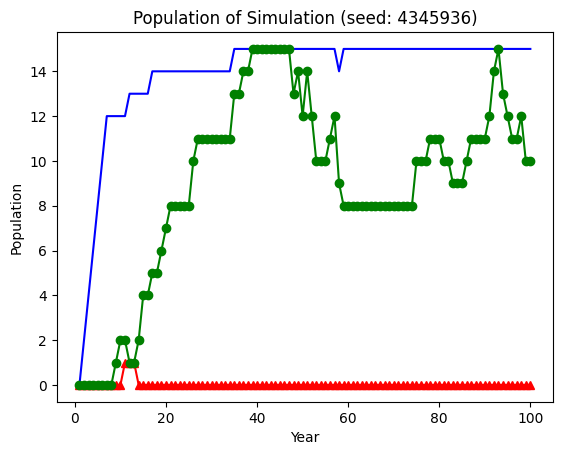

In [13]:
from neighborly.data_collection import DataCollector

data_collector = sim.world.resource_manager.get_resource(DataCollector)

population_table = data_collector.get_table_dataframe("population")

plt.plot(
    population_table["timestamp"],
    population_table["population"],
    color='blue'
)
plt.plot(
    population_table["timestamp"],
    population_table["demons"],
    color='red',
    marker='^'
)
plt.plot(
    population_table["timestamp"],
    population_table["demon_slayers"],
    color='green',
    marker='o'
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")